In [1]:
import nilearn
from nilearn import input_data
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from nilearn.decomposition import DictLearning
from nilearn.regions import RegionExtractor

import sklearn
from sklearn import svm
from sklearn import model_selection

import scipy
import scipy.cluster

import bct

import numpy as np

from matplotlib import pyplot as plt

import seaborn as sns

import os

from pathlib import Path
from scipy import io as sio
from pygsp import graphs


In [2]:
#Download the data of ABIDE for the different appraoches
path_STDGSP_STD_FC=Path('/SVM/all_site_intrafiltering_GlobalSR_k10_QC_svc_std+SG_STD_FC_0.01.npz')
path_STDGSP_EC_NS=Path('/SVM/all_site_intrafiltering_GlobalSR_k10_QC_svc_std+SG_EC_NS_0.01.npz')
path_STDGSP_CC_var=Path('/SVM/all_site_intrafiltering_GlobalSR_k10_QC_svc_std+SG_CC_var_0.01.npz')
path_STDGSP_Mean_MeanGSP=Path('/SVM/all_site_intrafiltering_GlobalSR_k10_QC_svc_std+SG_Mean_Mean+SG_0.01.npz')
path_STDGSP_kurtosis=Path('/SVM/all_site_intrafiltering_GlobalSR_k10_QC_svc_std+SG_kurtosis_kurtosis+SG_0.01_up.npz')
path_STDGSP_kurtosisGSP=Path('/SVM/all_site_intrafiltering_GlobalSR_k10_QC_svc_std+SG_kurtosis_kurtosis+SG_0.01.npz')
path_STDGSP_var_varGSP=Path('/SVM/all_site_intrafiltering_GlobalSR_k10_QC_svc_std+SG_var_var+SG_0.01.npz')

In [3]:
labels=np.load(os.path.join(path_STDGSP_STD_FC))['labels']
print(labels.shape)

abide_ts_std_all=np.load(os.path.join(path_STDGSP_STD_FC))['abide_ts_std']
print(abide_ts_std_all.shape)

abide_signals_fourier_std=np.load(os.path.join(path_STDGSP_STD_FC))['signals_fourier_std']
print(abide_signals_fourier_std.shape)

abide_ts_mean_all=np.load(os.path.join(path_STDGSP_Mean_MeanGSP))['abide_ts_mean']
print(abide_ts_mean_all.shape)

abide_signals_fourier_mean=np.load(os.path.join(path_STDGSP_Mean_MeanGSP))['signals_fourier_mean']
print(abide_signals_fourier_mean.shape)

abide_ts_kurtosis_all=np.load(os.path.join(path_STDGSP_kurtosis))['abide_ts_kurtosis']
print(abide_ts_kurtosis_all.shape)

abide_signals_fourier_kurtosis=np.load(os.path.join(path_STDGSP_kurtosisGSP))['signals_fourier_kurtosis']
print(abide_signals_fourier_kurtosis.shape)

abide_FC=np.load(os.path.join(path_STDGSP_STD_FC))['mat_connectivity']
print(abide_FC.shape)

abide_EC=np.load(os.path.join(path_STDGSP_EC_NS))['eig_cens']
print(abide_EC.shape)

abide_NS=np.load(os.path.join(path_STDGSP_EC_NS))['Node_strengths']
print(abide_NS.shape)

abide_CC=np.load(os.path.join(path_STDGSP_CC_var))['clusterings']
print(abide_CC.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/SVM/all_site_intrafiltering_GlobalSR_k10_QC_svc_std+SG_STD_FC_0.01.npz'

In [4]:
abide_ts_var_all=np.load(os.path.join(path_STDGSP_var_varGSP))['abide_ts_var']
print(abide_ts_mean_all.shape)

abide_signals_fourier_var=np.load(os.path.join(path_STDGSP_var_varGSP))['signals_fourier_var']
print(abide_signals_fourier_var.shape)

(871, 360)
(871, 360)


Create the graph

In [5]:
from scipy import io as sio
from pygsp import graphs

connectivity = sio.loadmat('SC_avg56.mat')['SC_avg56']
print(connectivity.shape)
coordinates = sio.loadmat('Glasser360_2mm_codebook.mat')['codeBook']
G = graphs.Graph(connectivity,gtype='HCP subject',lap_type='normalized',coords=coordinates)
#G = graphs.Graph(connectivity,gtype='HCP subject',lap_type='normalized')



(360, 360)


In [6]:
G.compute_fourier_basis()

Create the masker 

In [7]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.datasets import fetch_icbm152_2009

mnitemp = fetch_icbm152_2009()

glassermasker = NiftiLabelsMasker(labels_img='Glasser_masker.nii.gz',mask_img=mnitemp['mask'])
glassermasker.fit()

NiftiLabelsMasker(background_label=0, detrend=False, dtype=None,
         high_pass=None, labels_img='Glasser_masker.nii.gz', low_pass=None,
         mask_img='/home/tbuser/nilearn_data/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a_mask.nii.gz',
         memory=Memory(location=None), memory_level=1,
         resampling_target='data', smoothing_fwhm=None, standardize=False,
         t_r=None, verbose=0)

In [8]:
def visualization(k,data,LABELS):
    from sklearn.model_selection import KFold,cross_validate, StratifiedKFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.feature_selection import SelectKBest
    from sklearn.svm import SVC,LinearSVC
    from sklearn.pipeline import make_pipeline
    from nilearn.plotting import plot_stat_map
    from sklearn.model_selection import StratifiedShuffleSplit


    from nilearn.regions import signals_to_img_labels

    svc=LinearSVC(random_state=0,max_iter=100000,C=0.01)

    #cv = StratifiedKFold(n_splits=10)
    cv=StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

    kbest_img_all=[]

    pipe_clf= make_pipeline(StandardScaler(),SelectKBest(k=k), svc)

    scores = cross_validate(pipe_clf, data, y=LABELS, cv=cv,return_estimator=True, scoring='accuracy')

    for i in range (20):

        whichROI = (scores['estimator'][i].steps[1][1].inverse_transform(np.ones((1,k))))

        kbest_img = signals_to_img_labels(whichROI,'Glasser_masker.nii.gz',mnitemp['mask'])

        kbest_img_all.append(kbest_img)
        #plotting.plot_roi(kbest_img,title="Accuracy over folds : %0.4f for k=%0.1f" % (scores['test_score'][i],k),cut_coords=6,display_mode='z')
        #plt.show()
        
    return(kbest_img_all,scores)
    

In [10]:
kbest_img_all_std,scores_std=visualization(50,abide_ts_std_all,labels)
print(np.mean(scores_std['test_score']))

0.5657142857142856


In [16]:
kbest_img_all_mean,scores_mean=visualization(130,abide_ts_mean_all,labels)
print(np.mean(scores_mean['test_score']))

0.5211428571428572


In [11]:
kbest_img_all_var,scores_mean=visualization(50,abide_ts_var_all,labels)
print(np.mean(scores_mean['test_score']))

0.5597142857142857


In [11]:
kbest_img_all_kurtosis,scores_kurtosis=visualization(290,abide_ts_kurtosis_all,labels)
print(np.mean(scores_kurtosis['test_score']))

0.564


In [25]:
kbest_img_all_EC,scores_EC=visualization(20,abide_EC,labels)
print(np.mean(scores_EC['test_score']))

0.5648571428571427


In [26]:
kbest_img_all_NS,scores_NS=visualization(120,abide_NS,labels)
print(np.mean(scores_NS['test_score']))

0.5425714285714285


In [16]:
kbest_img_all_CC,scores_CC=visualization(50,abide_CC,labels)
print(np.mean(scores_CC['test_score']))

0.5705714285714286


In [29]:
kbest_img_all_FC,scores_FC=visualization(240,abide_FC,labels)
print(np.mean(scores_FC['test_score']))

0.5931428571428572


In [12]:
def visualization_GFT(k,data,LABELS):
    from sklearn.model_selection import cross_val_score,permutation_test_score,cross_val_predict
    from sklearn.model_selection import KFold,cross_validate, StratifiedKFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.feature_selection import SelectKBest
    from sklearn.svm import SVC,LinearSVC
    from sklearn.pipeline import make_pipeline
    from nilearn.plotting import plot_stat_map
    from sklearn.model_selection import StratifiedShuffleSplit


    from nilearn.regions import signals_to_img_labels


    svc=LinearSVC(random_state=0,max_iter=100000,C=0.01)


    cv=StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

    kbest_img_all_GSP=[]
   

    #isignal=G.igft(signals_fourier_std.T)

    pipe_clf= make_pipeline(StandardScaler(),SelectKBest(k=k), svc)

    scores = cross_validate(pipe_clf, data,y=LABELS, cv=cv,return_estimator=True, scoring='accuracy')
    
   

    allselU = []

    for i in range (20):

        whichU = (scores['estimator'][i].steps[1][1].inverse_transform(np.ones((1,k))))
        allselU.append(whichU)

        curimg = G.igft(whichU.T).T


        kbest_img_GSP= signals_to_img_labels(curimg,'Glasser_masker.nii.gz',mnitemp['mask'])

        kbest_img_all_GSP.append(kbest_img_GSP)
        #plotting.plot_stat_map(kbest_img_GSP_STD,title="Accuracy over folds : %0.4f for k=%0.1f" % (scores['test_score'][i],k),cut_coords=6,display_mode='z')
        #plt.show()
    return(kbest_img_all_GSP,scores)


In [8]:
## Permutation test figure with the proposed approach
from sklearn.model_selection import cross_val_score,permutation_test_score,cross_val_predict
from sklearn.model_selection import KFold,cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC,LinearSVC
from sklearn.pipeline import make_pipeline
from nilearn.plotting import plot_stat_map
from sklearn.model_selection import StratifiedShuffleSplit


from nilearn.regions import signals_to_img_labels


svc=LinearSVC(random_state=0,max_iter=100000,C=0.01)


cv=StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

kbest_img_all_GSP=[]
accuracies = []
std_accuracies= []

#isignal=G.igft(signals_fourier_std.T)

pipe_clf= make_pipeline(StandardScaler(),SelectKBest(k=180), svc)

scores = cross_validate(pipe_clf, abide_signals_fourier_std,y=labels, cv=cv,return_estimator=True, scoring='accuracy')

score, permutation_scores,pval = permutation_test_score(pipe_clf, abide_signals_fourier_std, n_permutations=100,y=labels, cv=cv, scoring='accuracy')
print("Classification score %s (pvalue : %s) for k=%s" % (score, pval,180))   
#View histogram of permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores',edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,label='Classification Score' ' (pvalue %.4f)' % pval)
plt.plot(2 * [1. / np.unique(labels).size], ylim, '--k', linewidth=3, label='Luck')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
#plt.show()
#plt.savefig('/media/tbuser/VOLUME2/Research/Artificial Intelligence in Medicine_paper/paper/permutation_Test.eps')

NameError: name 'abide_signals_fourier_std' is not defined

In [13]:
kbest_img_all_GSP_std,scores_std_GSP=visualization_GFT(50,abide_signals_fourier_std,labels)
print(np.mean(scores_std_GSP['test_score']))
print(np.std(scores_std_GSP['test_score']))

0.6008571428571428
0.030252002800961582


In [14]:
kbest_img_all_GSP_var,scores_var_GSP=visualization_GFT(50,abide_signals_fourier_var,labels)
print(np.mean(scores_var_GSP['test_score']))

0.572


In [20]:
kbest_img_all_GSP_mean,scores_mean_GSP=visualization_GFT(200,abide_signals_fourier_mean,labels)
print(np.mean(scores_mean_GSP['test_score']))

0.49542857142857144


In [19]:
kbest_img_all_GSP_kurtosis,scores_kurtosis_GSP=visualization_GFT(260,abide_signals_fourier_kurtosis,labels)
print(np.mean(scores_kurtosis_GSP['test_score']))

0.5425714285714286


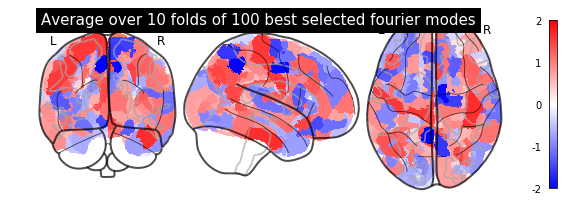

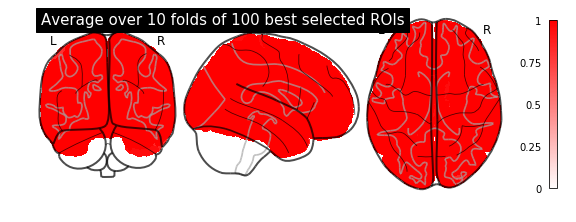

In [22]:
#from nilearn.plotting import plot_glass_brain

#curcmap = plt.cm.hot_r

#plot_glass_brain(mean_img(kbest_img_all_GSP_std),title='Average over 10 folds of 100 best selected fourier modes',colorbar=True,plot_abs=False,cmap=plt.cm.bwr)
#plt.show()

#plot_glass_brain(mean_img(kbest_img_all_std),title='Average over 10 folds of 100 best selected ROIs',cmap=plt.cm.bwr,colorbar=True)
#plt.show()


In [21]:
## save the figures in nii.gz format
from nilearn import plotting, image

result_img_STD = image.mean_img(kbest_img_all_std)
result_img_STD.to_filename('std.nii.gz')

result_img_STD_SG = image.mean_img(kbest_img_all_GSP_std)
result_img_STD_SG.to_filename('std_SG.nii.gz')

result_img_Var = image.mean_img(kbest_img_all_var)
result_img_Var.to_filename('var.nii.gz')

result_img_Var_SG = image.mean_img(kbest_img_all_GSP_var)
result_img_Var_SG.to_filename('var_SG.nii.gz')

result_img_CC = image.mean_img(kbest_img_all_CC)
result_img_CC.to_filename('CC.nii.gz')

In [ ]:
## Visualization of features for approaches which are significant
from nilearn.image import mean_img

cut_coords = [-32,-15,1,16,31,54]


f,ax = plt.subplots(ncols=1,nrows=5)
f.set_size_inches(20,20)

plotting.plot_stat_map(mean_img(kbest_img_all_std),title='STD',cut_coords=cut_coords,display_mode='z',cmap=plt.cm.bwr,figure=f,axes=ax[0])
plotting.plot_stat_map(mean_img(kbest_img_all_GSP_std),title='STD+SG',cut_coords=cut_coords,display_mode='z',cmap=plt.cm.bwr,threshold=0.1,figure=f,axes=ax[1])

plotting.plot_stat_map(mean_img(kbest_img_all_var),title='Var',cut_coords=cut_coords,display_mode='z',cmap=plt.cm.bwr,figure=f,axes=ax[2])
plotting.plot_stat_map(mean_img(kbest_img_all_GSP_var),title='Var+SG',cut_coords=cut_coords,display_mode='z',cmap=plt.cm.bwr,figure=f,axes=ax[3],threshold=0.1)

plotting.plot_stat_map(mean_img(kbest_img_all_CC),title='CC',cut_coords=cut_coords,display_mode='z',cmap=plt.cm.bwr,figure=f,axes=ax[4])
plotting.show()


In [18]:
#f.savefig('/media/tbuser/VOLUME2/Research/Artificial Intelligence in Medicine_paper/paper_V2/Abide_Maps_STD_STDSG_var_varsg_CC.pdf')

In [46]:
from nilearn import datasets 
fsaverage = datasets.fetch_surf_fsaverage()
listfiles=['var.nii.gz', 'std_SG.nii.gz', 'std.nii.gz', 'var_SG.nii.gz', 'CC.nii.gz']

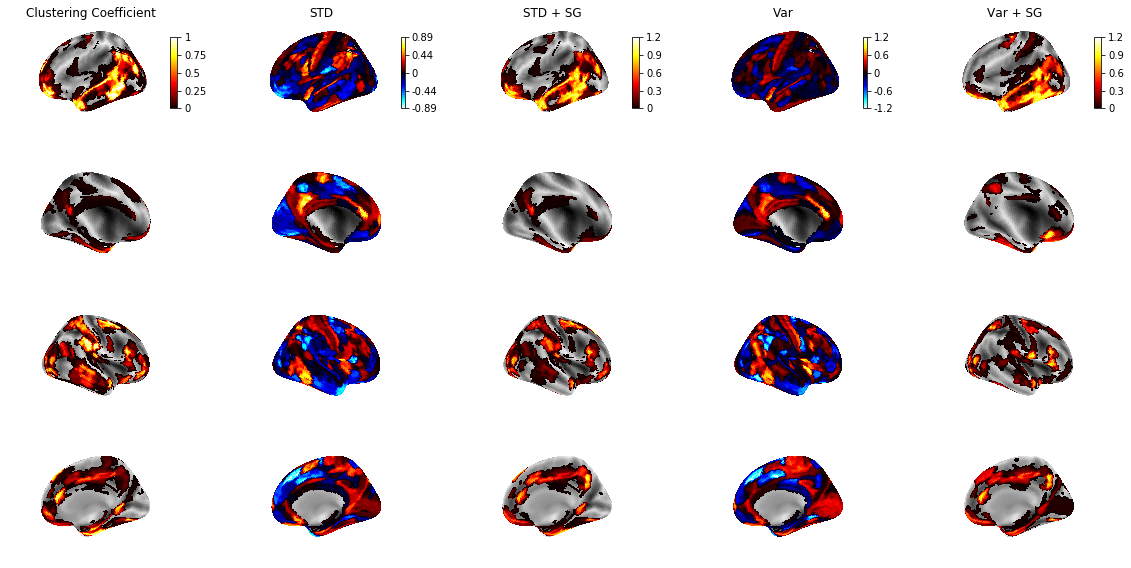

In [74]:
from nilearn.surface import vol_to_surf

alltitles = ['Clustering Coefficient','STD','STD + SG', 'Var', 'Var + SG']

fig,axes = plt.subplots(nrows=4,ncols=5,subplot_kw={'projection': '3d'},figsize=(20,10))




cols = alltitles

for i,curfile in enumerate(listfiles):
    
    curname = curfile[:-7]
    
    surf_left = fsaverage.infl_left
    surf_right = fsaverage.infl_right
    
    texture_left = vol_to_surf(curfile, fsaverage.pial_left)
    texture_right = vol_to_surf(curfile, fsaverage.pial_right)
    
    

    if (i==2)|(i==4):
        curvmax = 1.2
    else:
        curvmax = None
            
    
    plotting.plot_surf_stat_map(surf_mesh=surf_left,stat_map=texture_left,hemi='left',view='lateral',
                                bg_map=fsaverage.sulc_right,axes=axes[0,i],figure=fig,colorbar=(True),vmax=curvmax)
    
    plotting.plot_surf_stat_map(surf_mesh=surf_left,stat_map=texture_left,hemi='left',view='medial',
                               bg_map=fsaverage.sulc_right,axes=axes[1,i],figure=fig,colorbar=False,vmax=curvmax)
    
    plotting.plot_surf_stat_map(surf_mesh=surf_right,stat_map=texture_right,hemi='right',view='lateral',
                               bg_map=fsaverage.sulc_right,axes=axes[2,i],figure=fig,colorbar=False,vmax=curvmax)
    
    plotting.plot_surf_stat_map(surf_mesh=surf_right,stat_map=texture_right,hemi='right',view='medial',
                               bg_map=fsaverage.sulc_right,axes=axes[3,i],figure=fig,colorbar=False,vmax=curvmax)
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
pad = 5 # in points


#plt.savefig('Abide_maps.eps')


plt.show()

